In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from neuralop.utils import count_model_params
from neuralop import LpLoss
from utils.utils import get_dataloaders, TensorDataset
import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from utils.losses import EnergyScore, KernelScore, VariogramScore
from models.fno import FNO1d
from models.pfno import FNO_reparam
from models.mcdropout import generate_mcd_samples

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Subsampling rate
sampling_rate = 2
ntrain = 1500
ntest = 150
batch_size = 64

t1 = 5
t2 = 6
data = np.load("../data/KS-Equation/ks_1d_data.npy").astype(np.float32)

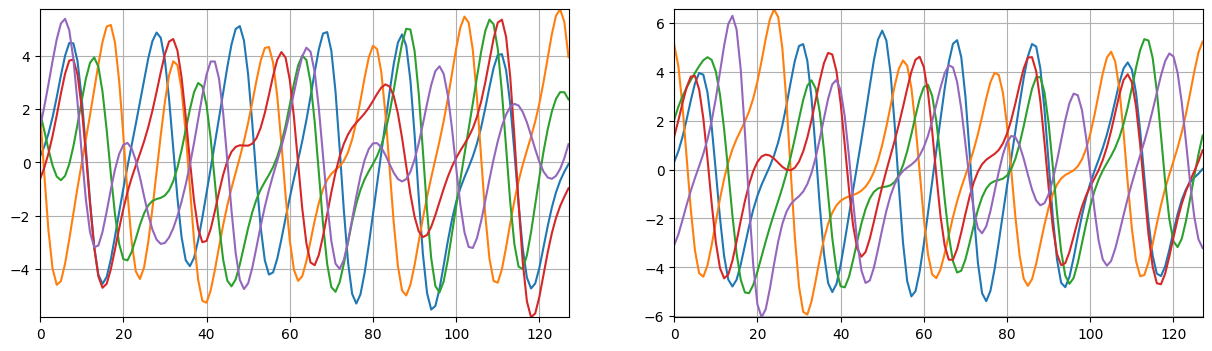

In [3]:
# Example plot
n_samples = np.random.randint(0,ntrain,5)

fig, axs = plt.subplots(1, 2, figsize = (15,4))
index = 0
for i in n_samples:
    axs[0].plot(data[i, t1])
    axs[1].plot(data[i, t2])


axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

In [4]:
grid_range = 1

x_data = torch.tensor(data[:,t1])
y_data = torch.tensor(data[:,t2])
x_data = (x_data - x_data.mean()) / x_data.std()
y_data = (y_data - y_data.mean()) / y_data.std()
size_x = x_data.shape[1]
size_x_train = int(size_x/sampling_rate)

# Add channel dimension
x_data = x_data[:, None, :]
y_data = y_data[:, None, :]

x_train, y_train = x_data[:ntrain,:,::sampling_rate], y_data[:ntrain,:,::sampling_rate]
x_test, y_test = x_data[-ntest:], y_data[-ntest:]

# Add grid
gridx_train = torch.tensor(np.linspace(0, grid_range, size_x_train), dtype=torch.float)
gridx_train = gridx_train.reshape(1, 1, size_x_train)
gridx_test = torch.tensor(np.linspace(0, grid_range, size_x), dtype=torch.float)
gridx_test = gridx_test.reshape(1, 1, size_x)


x_train = torch.cat((x_train, gridx_train.repeat([ntrain, 1, 1])), dim=1)
x_test = torch.cat((x_test, gridx_test.repeat([ntest, 1, 1])), dim=1)

train_loader = torch.utils.data.DataLoader(TensorDataset(x_train, y_train),
                                        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(TensorDataset(x_test, y_test),
                                        batch_size=batch_size, shuffle=False)
test_data = [x_test, y_test]

# Losses and parameters

In [5]:
l2loss = LpLoss(d=1, p=2, L = 50.0)
energy_score = EnergyScore(d = 1, p = 2, type = "lp", L = 50.0)
#energy_score = KernelScore(d=1, p=2, type = "lp",  L = 50.0, kernel ="gauss", gamma = 10)
variogram_score = VariogramScore(p=1)

# Training parameters
epochs = 20
learning_rate = 0.001
dropout_rate = 0.1

# MC dropout

In [6]:
model = FNO1d(n_modes=16, hidden_channels=32, projection_channels=64, lifting_channels=64,
             in_channels = 2, dropout_rate=dropout_rate)
model = model.to(device)
n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 139745 parameters.


In [7]:
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [8]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for sample in train_loader:
        x,y = sample
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(x)
        
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2 = l2loss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            x,y = sample
            x = x.to(device)
            y = y.to(device)

            out = model(x)
            test_l2 += l2loss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-MSE-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_mse, train_l2, test_l2))

Epoch-0, Time-0.6147, Train-MSE-0.9048, Train-L2-0.9704, Test-L2-1.0342
Epoch-1, Time-0.4871, Train-MSE-0.5479, Train-L2-0.7513, Test-L2-0.7103
Epoch-2, Time-0.4915, Train-MSE-0.1960, Train-L2-0.4397, Test-L2-0.3678
Epoch-3, Time-0.4956, Train-MSE-0.0992, Train-L2-0.3144, Test-L2-0.2699
Epoch-4, Time-0.4952, Train-MSE-0.0718, Train-L2-0.2685, Test-L2-0.2582
Epoch-5, Time-0.5041, Train-MSE-0.0583, Train-L2-0.2418, Test-L2-0.1837
Epoch-6, Time-0.4929, Train-MSE-0.0488, Train-L2-0.2218, Test-L2-0.1606
Epoch-7, Time-0.5578, Train-MSE-0.0440, Train-L2-0.2108, Test-L2-0.1595
Epoch-8, Time-1.0453, Train-MSE-0.0409, Train-L2-0.2027, Test-L2-0.1387
Epoch-9, Time-1.4108, Train-MSE-0.0373, Train-L2-0.1942, Test-L2-0.1482
Epoch-10, Time-1.6852, Train-MSE-0.0355, Train-L2-0.1895, Test-L2-0.1289
Epoch-11, Time-1.3391, Train-MSE-0.0339, Train-L2-0.1854, Test-L2-0.1291
Epoch-12, Time-1.6705, Train-MSE-0.0325, Train-L2-0.1815, Test-L2-0.1137
Epoch-13, Time-1.2936, Train-MSE-0.0328, Train-L2-0.1820, Tes

In [9]:
# %%
model.train()
""" Prediction """
pred = []
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        x,y = sample
        x = x.to(device)
        y = y.to(device)
        out = generate_mcd_samples(model, x, y.shape, n_samples=100)
        pred.append( out )


pred = torch.cat((pred))
mse_dropout = F.mse_loss(pred.mean(axis = -1).view(-1, size_x), y_test.view(-1, size_x)).item()
es_dropout = energy_score(pred, y_test).item()

print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.007528853602707386
ES: 0.4326724112033844


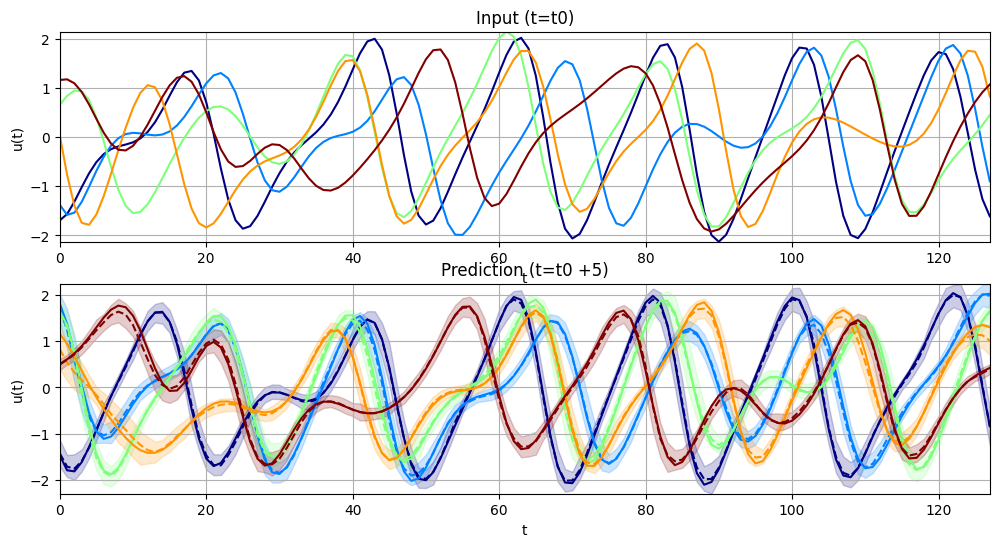

In [10]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(5):
    axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
    axs[1].plot(pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
    axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
    # Plot confidence bands
    axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                        pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
    index += 1

axs[0].set_title('Input (t=t0)')
axs[1].set_title('Prediction (t=t0 +5)')
axs[0].set_xlabel('t')
axs[1].set_xlabel('t')
axs[0].set_ylabel('u(t)')
axs[1].set_ylabel('u(t)')
axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

# Laplace approximation

In [19]:
from torch.nn.utils import parameters_to_vector, vector_to_parameters
from laplace import Laplace
from models.laplace import LA_Wrapper

In [20]:
la_pfno = LA_Wrapper(model, n_samples=500, method = "last_layer", hessian_structure = "full")

In [21]:
la_pfno.fit(train_loader)
la_pred = la_pfno.predictive_samples(x_test[0:5])

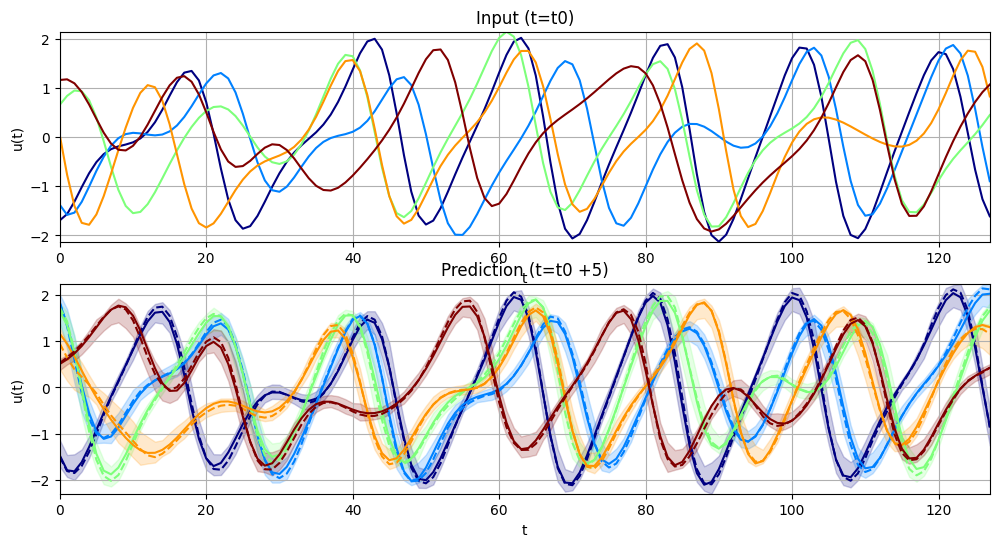

In [22]:
x_test, y_test = test_data
# %%


colormap = plt.cm.jet
colors = [colormap(i) for i in np.linspace(0, 1, 5)]

""" Plotting """ 
fig, axs = plt.subplots(2, 1, figsize = (12, 6))
index = 0
for i in range(5):
    axs[1].plot(y_test[i, 0].cpu().numpy(), color=colors[index], label='Actual')
    axs[1].plot(la_pred[i,0].mean(axis = -1).cpu().numpy(), '--', color=colors[index], label='Prediction')
    axs[0].plot(x_test[i,0].cpu().numpy(), color=colors[index], label='Actual')
    # Plot confidence bands
    axs[1].fill_between(np.arange(0, size_x), pred[i,0].quantile(0.025, axis = -1).cpu().numpy(),
                        pred[i,0].quantile(0.975, axis = -1).cpu().numpy() , color=colors[index], alpha=0.2)
    index += 1

axs[0].set_title('Input (t=t0)')
axs[1].set_title('Prediction (t=t0 +5)')
axs[0].set_xlabel('t')
axs[1].set_xlabel('t')
axs[0].set_ylabel('u(t)')
axs[1].set_ylabel('u(t)')
axs[0].grid(True)
axs[0].margins(0)
axs[1].grid(True)
axs[1].margins(0)

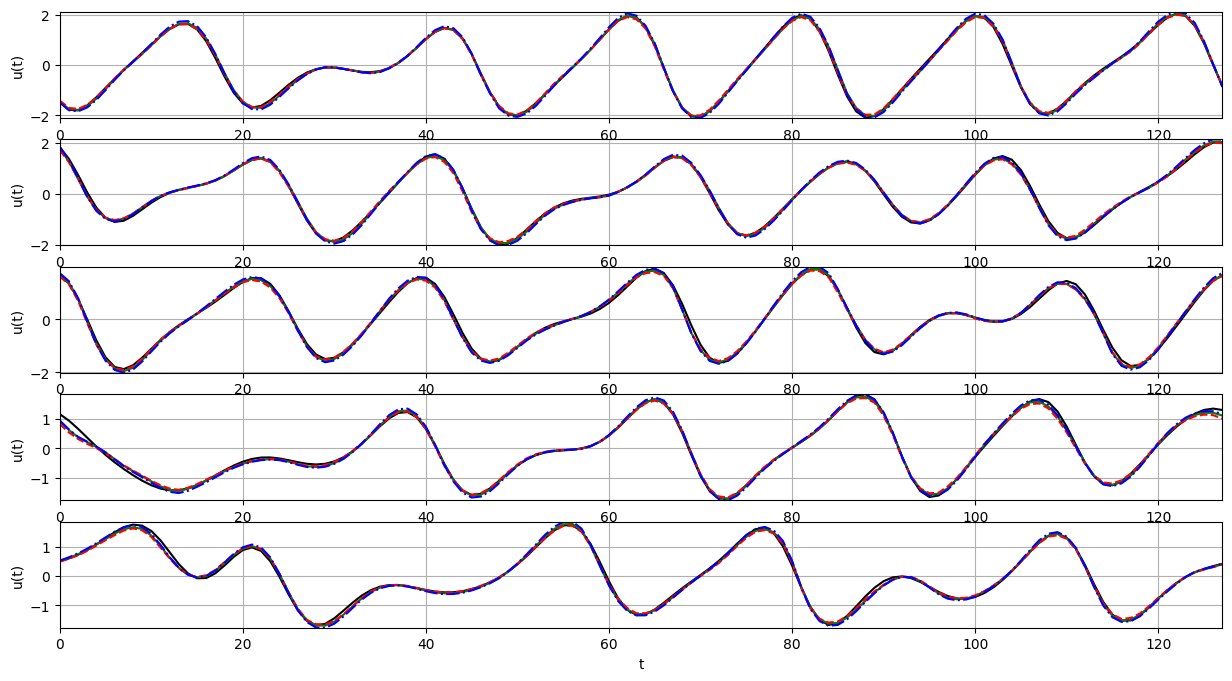

In [23]:
# Comparison

x_test, y_test = test_data
# %%
model.eval()
map = model(x_test[0:5])
dropout_mean = pred.mean(axis = -1)
la_mean = la_pred.mean(axis = -1)


""" Plotting """ 
fig, axs = plt.subplots(5, 1, figsize = (15, 8))
index = 0
for i in range(5):
    axs[i].plot(y_test[i, 0].cpu().numpy(), color = "black")
    axs[i].plot(map[i,0].detach().cpu().numpy(), color = "green")
    axs[i].plot(dropout_mean[i,0].detach().cpu().numpy(), '--', color = "red")
    axs[i].plot(la_mean[i,0].detach().cpu().numpy(), '-.', color="blue")

    axs[i].set_xlabel('t')
    axs[i].set_ylabel('u(t)')
    axs[i].grid(True)
    axs[i].margins(0)